# Tutorial
20/10/21

[Link to Setup](#Setup)

[Link to Input](#Input)

[Link to Data preparation](#Data-preparation)

[Link to NN](#NN)

[Link to Evaluation](#Evaluation)

# Setup

Import of python packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import json
import pyarrow
import numpy as np

#For plotting purposes
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import matplotlib.ticker as tck
plt.style.use('classic')
rcParams['figure.facecolor'] = '1'
rcParams['patch.force_edgecolor'] = False

#For directory management
import os
from joblib import load, dump
pandainput = "pandas_tqXv8.feather"
outputdir = "./Models/test"
user = "salvador" #<--- change this!

#Options
kfoldtraining = 0 #0 to the number of slices in the dataset - 1 (default 2 slices)
reframelep_phi = True
features = [] #name of the input variables for the NN 
for i in range(0,6): #Will need information from 6 jets, lepton and MET
    features+=['jet'+str(i)+'_pt_bord', 'jet'+str(i)+'_eta_bord', 'jet'+str(i)+'_phi_bord', 'jet'+str(i)+'_m_bord', 'jet'+str(i)+'_btagw_discrete_bord']
features+=["lep1_pt","lep1_eta","lep1_phi","met","met_phi"]
features+=["mb1b2","mb1b3","mb2b3","DRb1b2","DRb1b3","DRb2b3"]

Check if the GPU is going to be used

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2021-10-21 13:52:20.625155: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-21 13:52:20.712418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3e:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-21 13:52:20.713219: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-21 13:52:20.716610: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-21 13:52:20.719852: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-10-21 13:52:20.720750: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

Generate directories if needed

The input panda file is preferibly stored in /tmp/, a local directory of the computer, as pic uses centralised disks with reading delays. It could be also loaded in cache memory

In [3]:
if not os.path.isdir(outputdir):
    print("Making output dir",outputdir) #output dir to store training output and plots
    os.makedirs(outputdir, exist_ok=True)
if not os.path.isdir("/tmp/"+user):
    print ("Making tmp dir")
    os.mkdir("/tmp/"+user)

!ls -lshtr /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/*.feather #use ! to use jupyter as a console prompt
!cp /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/$pandainput /tmp/$user/
!ls /tmp/$user/

370M -rw-r--r-- 1 salvador atlas 370M Mar 14  2021 /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/pandas_Wh_v0_6jin4bin.feather
2.2G -rw-r--r-- 1 salvador atlas 2.2G Mar 31  2021 /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/pandas_Hpcb_v0.feather
2.2G -rw-r--r-- 1 salvador atlas 2.2G Apr 23 12:21 /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/pandas_Hpcb_v1.feather
641M -rw-r--r-- 1 salvador atlas 641M May  5 11:55 /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/pandas_Wh_v1_6jin4bin.feather
2.3G -rw-r--r-- 1 salvador atlas 2.3G May  5 17:44 /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/pandas_Hpcb_v2.feather
2.3G -rw-r--r-- 1 salvador atlas 2.3G May  9 00:31 /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/pandas_tqXv3.feather
3.4M -rw-r--r-- 1 salvador atlas 3.4M May 18 17:32 /data/at3/scratch/salvador/IFAE-tXq/NN/IFAE_NNTools/PandasWriter/pandas_Wh_v3_6jin4bin.feather
641M -rw

# Input

The pandas format allows visualisation and easy data-analysis management. This input is a big matrix with the variables as columns and events as rows
In this particular example not only variables for the input are stored, you can find saved the overall weight, process, sample group, region...

In [4]:
df_mc = pd.read_feather("/tmp/"+user+"/"+pandainput) #load dataframe
df_mc = df_mc[~((df_mc.X_mass==160)&(df_mc.nomWeight_weight_mc > 700))] #removing some wrong events and regions
df_mc = df_mc[~((df_mc.region=="c1l7jin3bex")|(df_mc.region=="c1l7jin4bin"))]
df_mc["weight"]*=139000.0
masses = [30,40,50,60,70,80,90,100,120,140,150,160]

print ("Shape of the dataset",df_mc.shape) #shape of the matrix (rows x columns --> events x variables)
print ("List of variables",df_mc.columns.unique()) #List of the names of the variables stored
print ("List of regions",df_mc.region.unique()) #List of Unique instances of the variable regions
df_mc.head()

Shape of the dataset (5487717, 72)
List of variables Index(['index', 'lep1_pt', 'DRb1b3', 'jet0_m_bord', 'jet4_m_bord',
       'jet1_y_bord', 'dRmin_bb', 'jet0_phi_bord', 'jet5_btagw_discrete_bord',
       'jet0_pt_bord', 'jet2_m_bord', 'nomWeight_weight_jvt', 'jet5_phi_bord',
       'Wlep_m', 'jet1_eta_bord', 'jet5_eta_bord', 'jet3_phi_bord',
       'nomWeight_weight_leptonSF', 'met_phi', 'nomWeight_weight_btag',
       'nomWeight_weight_mc', 'jet0_btagw_discrete_bord',
       'nomWeight_weight_norm', 'jet3_pt_bord', 'jet3_y_bord', 'jet2_pt_bord',
       'jet2_eta_bord', 'jet4_pt_bord', 'jet2_phi_bord',
       'jet1_btagw_discrete_bord', 'mbb_leading_bjets', 'dRmax_bb',
       'event_number', 'jet1_pt_bord', 'Wlep_pt', 'lep1_eta', 'jet5_m_bord',
       'Wlep_eta', 'jet5_pt_bord', 'jet4_phi_bord', 'jet2_y_bord', 'DRb1b2',
       'jet0_eta_bord', 'jets_n', 'jet3_eta_bord', 'jet1_phi_bord', 'DRb2b3',
       'mbb_mindr', 'Wlep_phi', 'jet3_btagw_discrete_bord',
       'jet4_btagw_discrete_

,index,lep1_pt,DRb1b3,jet0_m_bord,jet4_m_bord,jet1_y_bord,dRmin_bb,jet0_phi_bord,jet5_btagw_discrete_bord,jet0_pt_bord,jet2_m_bord,nomWeight_weight_jvt,jet5_phi_bord,Wlep_m,jet1_eta_bord,jet5_eta_bord,jet3_phi_bord,nomWeight_weight_leptonSF,met_phi,nomWeight_weight_btag,nomWeight_weight_mc,jet0_btagw_discrete_bord,nomWeight_weight_norm,jet3_pt_bord,jet3_y_bord,jet2_pt_bord,jet2_eta_bord,jet4_pt_bord,jet2_phi_bord,jet1_btagw_discrete_bord,mbb_leading_bjets,dRmax_bb,event_number,jet1_pt_bord,Wlep_pt,lep1_eta,jet5_m_bord,Wlep_eta,jet5_pt_bord,jet4_phi_bord,jet2_y_bord,DRb1b2,jet0_eta_bord,jets_n,jet3_eta_bord,jet1_phi_bord,DRb2b3,mbb_mindr,Wlep_phi,jet3_btagw_discrete_bord,jet4_btagw_discrete_bord,jet4_eta_bord,met,jet5_y_bord,mb1b2,jet2_btagw_discrete_bord,mbb_maxdr,m_jj_leading_jets,jet1_m_bord,lep1_phi,dRavg_bb,mb1b3,mb2b3,jet4_y_bord,jet0_y_bord,jet3_m_bord,nomWeight_weight_pu,bjets_n,weight,process,X_mass,region
0,0,101.330802,0.487419,6.822823,0.0,-0.563969,0.487419,1.921955,0.0,50.091002,6.211140,0.982290,0.0,80.400002,-0.565284,0.0,-0.970096,1.012379,2.275517,1.104221,736.927429,4.565,1.316947e-09,38.231326,-0.191757,42.144307,-0.276446,0.0,2.228811,4.565,127.311031,1.919988,804346787.0,126.909428,100.245386,0.497498,0.0,0.623237,0.0,0.0,-0.273564,1.725627,0.102258,4.0,-0.193645,0.330673,1.919988,25.953660,-2.388896,0.665,0.0,0.0,33.167275,0.0,127.311031,4.565,121.908783,127.311031,9.113168,-2.118678,1.377678,25.953660,121.908783,0.0,0.101325,5.411415,0.980169,3.0,0.152407,ttbarlight,-1,c1l4jex3bex
1,1,130.046850,1.004634,17.024717,0.0,0.680723,1.004634,-1.363835,0.0,155.561476,11.549511,1.186342,0.0,80.400002,0.685926,0.0,1.989619,0.979871,1.077354,0.990828,736.927429,4.565,1.316947e-09,183.700212,1.048315,58.924237,1.111413,0.0,-1.230117,4.565,365.778265,2.621092,804346391.0,152.049867,147.935804,2.013507,0.0,2.138887,0.0,0.0,1.096299,2.621092,2.107109,4.0,1.057200,2.716996,2.374505,106.606302,-0.192192,0.665,0.0,0.0,51.246510,0.0,365.778265,4.565,365.778265,387.843307,20.219066,-0.437168,2.000077,106.606302,181.629950,0.0,2.101330,27.834939,0.124514,3.0,0.019645,ttbarlight,-1,c1l4jex3bex
2,2,56.732503,2.208648,13.328539,0.0,1.673997,2.208648,-0.617965,0.0,101.123778,8.567966,1.000000,0.0,80.400001,1.681491,0.0,2.946453,1.082103,0.886421,0.993791,736.927429,4.565,1.316947e-09,70.192316,0.744872,61.324479,-0.039323,0.0,-2.379537,4.565,184.390392,2.883247,804349052.0,81.151871,83.885120,1.294409,0.0,0.950688,0.0,0.0,-0.038945,2.883247,1.292964,4.0,0.746587,2.238985,2.394223,167.427247,0.305538,0.665,0.0,0.0,36.966818,0.0,184.390392,4.565,184.390392,184.390392,10.328939,-0.060129,2.495373,167.427247,173.539104,0.0,1.285567,5.175639,0.937222,3.0,0.141996,ttbarlight,-1,c1l4jex3bex
3,3,76.705183,0.971246,7.226594,0.0,-2.209389,0.971246,-2.971387,0.0,102.925161,6.580217,0.989040,0.0,80.400002,-2.215108,0.0,0.223497,1.055571,0.938674,1.111441,737.113770,4.565,1.316947e-09,45.852811,-1.208330,48.415709,-1.134918,0.0,2.484011,4.565,264.448653,3.163512,804367280.0,97.407817,72.190007,-1.074201,0.0,-1.414373,0.0,0.0,-1.127492,3.163512,-0.626898,4.0,-1.213966,-0.235442,2.926129,68.797680,-0.772004,0.665,0.0,0.0,45.965869,0.0,264.448653,4.565,264.448653,264.448653,10.574327,-1.191963,2.353629,68.797680,156.544006,0.0,-0.625532,5.339134,1.144528,3.0,0.186643,ttbarlight,-1,c1l4jex3bex
4,4,102.774208,2.964671,11.155804,0.0,-0.245629,0.896953,2.752213,0.0,97.832802,10.362208,0.989974,0.0,80.400001,-0.246508,0.0,-2.366132,1.000434,1.931764,1.073554,735.384155,4.565,1.316947e-09,26.128827,-1.338853,71.834113,0.325578,0.0,-0.211472,4.565,344.475375,2.964671,804373682.0,287.141045,240.125229,0.039344,0.0,-0.252855,0.0,0.0,0.322354,2.707490,0.402019,4.0,-1.346688,-0.902300,0.896953,132.962903,2.120658,0.665,0.0,0.0,143.498585,0.0,344.475375,4.565,168.526083,344.475375,24.557380,2.385936,2.189705,168.526083,132.962903,0.0,0.399560,3.517881,0.092410,3.0,0.013431,ttbarlight,-1,c1l4jex3bex


The items can be accessed array-like  ``df_mc["region"][10:20]``
but pandas has built-in functions that are very useful to manage all events at the same time

Its mandatory to know your dataset and your features and how to access the information you need!

Here is a method to reframe the phi angle and make sure is within [-$\pi$,$\pi$]

In [5]:
if reframelep_phi:
    #snipet to reframe phi taking phi_lep as the origin
    for i in range(0,6):
        df_mc["jet"+str(i)+"_phi_bord"]=df_mc["jet"+str(i)+"_phi_bord"]-df_mc["lep1_phi"]
        df_mc.loc[(df_mc["jet"+str(i)+"_phi_bord"]>np.pi),"jet"+str(i)+"_phi_bord"] -= 2*np.pi #careful not to exceed angle boundaries
        df_mc.loc[(df_mc["jet"+str(i)+"_phi_bord"]< -np.pi),"jet"+str(i)+"_phi_bord"] += 2*np.pi

    df_mc["met_phi"]=df_mc["met_phi"]-df_mc["lep1_phi"]
    df_mc.loc[(df_mc["met_phi"]>np.pi),"met_phi"] -= 2*np.pi
    df_mc.loc[(df_mc["met_phi"]< -np.pi),"met_phi"] += 2*np.pi
    
    features.remove("lep1_phi") #the angle shouldn't be use, as its 0 by construction
    features.remove('jet0_btagw_discrete_bord') #removing other irrelevant variables
    features.remove('jet1_btagw_discrete_bord')
    features.remove('jet2_btagw_discrete_bord')
    features.remove('jet0_m_bord')
    features.remove('jet1_m_bord')
    features.remove('jet2_m_bord')
    features.remove('jet3_m_bord')
    features.remove('jet4_m_bord')
    features.remove('jet5_m_bord')

Here there is a method to obtain the minimum and the maximum of the features

In [6]:
print("%5s %20s   %12s   %12s"%("index","Variable","min","max"))
j=0
var_min = []
var_max = []
for i in features:    #Table to save the min and max ranges of variables for the histogram
    var_min.append(df_mc[i].min())
    var_max.append(df_mc[i].max())
    print("%5d %20s   %12.3f   %12.3f"%(j,i,var_min[j],var_max[j]))
    j=j+1

index             Variable            min            max
    0         jet0_pt_bord         25.000       1818.198
    1        jet0_eta_bord         -2.500          2.500
    2        jet0_phi_bord         -3.142          3.142
    3         jet1_pt_bord         25.000       2058.654
    4        jet1_eta_bord         -2.500          2.500
    5        jet1_phi_bord         -3.142          3.142
    6         jet2_pt_bord         25.000       1926.686
    7        jet2_eta_bord         -2.500          2.500
    8        jet2_phi_bord         -3.142          3.142
    9         jet3_pt_bord         25.000       2126.193
   10        jet3_eta_bord         -2.500          2.500
   11        jet3_phi_bord         -3.142          3.142
   12 jet3_btagw_discrete_bord          0.665          4.565
   13         jet4_pt_bord          0.000       2069.506
   14        jet4_eta_bord         -2.500          2.500
   15        jet4_phi_bord         -3.142          3.142
   16 jet4_btagw_discrete_b

# Data preparation

Those are the main classes and functions needed to prepare the input for the training

It is added here for debugging purposes but it is implemented as a main package. Their purpose is explained in next cells

In [7]:
import numpy as np
import pandas as pd
from sklearn.utils import _safe_indexing, check_random_state
from itertools import chain
from sklearn.utils import shuffle
from scipy.stats import rv_discrete

def variance(values, weights=None, axis=0):
    """ returns weighted (biased) variance
        values: array/series with values
        weights: array/series with weights (same dimension as values)
    """
    
    average = np.average(values, weights=weights, axis=axis)
    variance = np.average((values-average)**2, weights=weights, axis=axis)
    return variance

class TrainingFrame:
    """Class that provides the tXq data for machine learning"""
    
    def __init__(self, pandasframe, feature_names, backgroundclass=-1):
        """Constructor to set data frame, features columns name and class label for background"""
        self.pandasframe = pandasframe
        self.backgroundclass = backgroundclass
        self.foldvar = "event_number"
        self.feature_names = feature_names
        self.random_state = 123456789
        self.mask = -1
        self.signalprefix = "X_"
        self.massvar = "X_"
    def get_pandasframe_mask(self, region, masses):
        """return a mask (true/false) for the specified options
           region: string name of the region
           masses: string "all" or list of masses to return
        """
        if region!="":
            regionseries = self.pandasframe.region==region
        else:
            regionseries = pd.Series([True]*self.pandasframe.shape[0],index=self.pandasframe.index)
        
        if masses=="all":
            return regionseries
        else: #This wont work for Hpmass style of process
            issignalseries = self.pandasframe.process.str.contains(self.signalprefix+str(masses[0]))
            for imass in masses[1:]:
                issignalseries = (issignalseries | self.pandasframe.process.str.contains(self.signalprefix+str(imass)) )
        
        isbackgroundseries =~ self.pandasframe.process.str.contains(self.signalprefix)
            
        return regionseries & (issignalseries | isbackgroundseries)
                                    
    def get_features_classes_weights(self,region,masses,addmass,absoluteWeight):
        """returns features data frame, classes series and weights series
           region: string, region of the events to be returned
           masses: string "all" or list specifying the masses to return
           addmass: bool, if True the mass is added to the feature matrix (parameterised ML training)
           abosluteWeight: bool, if True the absolute value of weight will be returned (default)
        """
        
        self.mask = self.get_pandasframe_mask(region,masses) #filters by region and masses
        if addmass:
            features = self.pandasframe[self.mask].loc[:,self.feature_names+[self.massvar+"mass"]].copy()
            classes = self.pandasframe[self.mask].process.apply(lambda proc:self.backgroundclass if not self.signalprefix in proc else int(proc.split(self.signalprefix)[1]))

        else:
            features = self.pandasframe[self.mask].loc[:,self.feature_names].copy() 
            classes = self.pandasframe[self.mask].process.apply(lambda proc:self.backgroundclass if not self.signalprefix in proc else 1)

        
        weights = self.pandasframe[self.mask].weight
        if absoluteWeight:
            weights = abs(weights)
        
        features.reset_index(inplace = True, drop = True)
        weights.reset_index(inplace = True, drop = True)
        classes.reset_index(inplace = True, drop = True)
        return features, classes, weights
        
    def get_split_series(self,rows):
        """return a series of integers 0,1,2 which sample of training, testing and evaluation belongs to."""
        #splitdf = pd.DataFrame([True]*rows)
        #splitdf = splitdf.apply(lambda x: 0 if x.name%10 in [0,1] else 1 if x.name%10 in [2,3] else 2 if x.name%10 in [4,5] else 3 if x.name%10 in [6,7] else 4, axis=1)
        #splitdf = splitdf.apply(lambda x: x.name%2, axis=1)
        #return #pd.Series(splitdf)
        #pd.Series([i%2 for i in range(rows)])
        return pd.Series([i%5 for i in range(rows)])
    
    
    def prepare(self, masses="all", region="", addmass=False, absoluteWeight=True,ifold=0):
        """returns feature matrices, class labels and weights for training, testing and evaluation
           region: string, region of the events to be returned
           masses: string "all" or list specifying the masses filter
           addmass: bool if True the mass column is added to the feature matrix
           absoluteWeight: bool, if true the absolute value of the weights will be returned
        """
        features, classes, weights = self.get_features_classes_weights(region,masses,addmass,absoluteWeight)
        split_series = self.pandasframe[self.mask][self.foldvar]%5  #self.get_split_series(classes.shape[0])
        
        trainset = np.where( (split_series==ifold%5) | (split_series==(ifold+1)%5) | (split_series==(ifold+2)%5) )[0]
        valset   = np.where( split_series==(ifold+3)%5 )[0]
        testset  = np.where( split_series==(ifold+4)%5 )[0]
        
        #trainset = np.where( split_series==ifold%2 )[0]
        #valset   = np.where( split_series==(ifold+1)%2 )[0]
        #testset  = np.where( split_series==(ifold+99) )[0]        
        
        rng = check_random_state(self.random_state)
        rng.shuffle(trainset)
        rng.shuffle(valset)
        rng.shuffle(testset)
        
        return list(chain.from_iterable((_safe_indexing(a,trainset),
                                         _safe_indexing(a,valset),
                                         _safe_indexing(a,testset)) for a in [features,classes,weights]))
    
class WeightScaler():
    """Class that makes the integral of the signal/bkg weights be equal, for several categories the distribution as a function of the class variable is flattened"""
    def __init__(self, backgroundclass=-1,norm=0.5):
        """
        backgroundlcass: label for bgk
        norm: value for the integral of weights
        """
        self.backgroundclass = backgroundclass
        self.norm = norm
        self.scale_={}
        
    def fit(self,X,y,w):
        """
        learns the sum of weights for all classes and calculates a scale factor for each class so that the sum of weights for bkg is 'norm' and the sum of weights for signal is flattened with total integral 'norm' 
        X: feature matrix, to keep structure (ignored)
        y: series of class labels
        w: Series of sample weights
        """
        classes=sorted(np.unique(y))
        classes.remove(self.backgroundclass)
        
        differences={}
        if len(classes)>1: #more than 1 signal
            #set the differences between signal points
            differences={classes[i]:(classes[i+1]-classes[i-1])/2 for i in range(1,len(classes)-1) if classes[i]>0}
            differences[classes[0]]=classes[1]-classes[0]
            differences[classes[-1]]=classes[-1]-classes[-2]
            diffsum=sum(differences.values())
            print (differences, "->", diffsum)
        else:
            differences[classes[0]]=1
            diffsum=1
        
        for classlabel in classes:
            sumweight=w[y==classlabel].sum()
            self.scale_[classlabel]=differences[classlabel]/(2*sumweight*diffsum)
        sumweight=w[y==self.backgroundclass].sum()
        self.scale_[self.backgroundclass]=self.norm/sumweight
        return
        
    def transform(self,X,y,w,copy=None):
        """
        Transforms the sum of weights for all classes applying the corresponding scale of each label
        """
        
        for classlabel in self.scale_:
            w[y==classlabel]*=self.scale_[classlabel]
        return X,y,w 

class BackgroundRandomizer():
        """
        Class that assigns random signal mass hypotheses to bkg training data with the PDF learned from signal for parameterised training
        """
        
        def __init__(self,backgroundclass=-1,verbose=False):
            """
            backgroundclass: label for background
            verbose: print debug information if True
            """
            
            self.backgroundclass = backgroundclass
            self.verbose = verbose
            self.randomseed = 123456789
            self.massvar = "X_mass"
            self.xk = []
            self.pk = []
        
        def fit(self, X, y, w):
            """
            determines the mass PDF for signal events
            X: features
            y: parameter for signal, background class for bkg
            w: weights for events (ignored)
            """
            self.xk = []
            self.pk = []
            signalsum = np.sum(w[y!=self.backgroundclass])
            for name, group in w.groupby(y):
                print("name",name, "group",group,"sum",group.sum())
                if name!=self.backgroundclass:
                    self.xk.append((-1)*name)
                    self.pk.append(group.sum()/signalsum)
            if self.verbose:
                print("Signal PDF:",self.xk,self.pk)
        
        def transform(self, X, y, w):
            """
            randomly assigns signal labels according to fitted pdf
            X: features
            y: parameter for signal, background class for bkg
            w: weights for events. Bkg weights are going to be set to have same sum as the weights of the signal label assigned
            """
            
            np.random.seed(seed=self.randomseed+len(y)) #not to have the same random seed for test and train
            custm=rv_discrete(values=(self.xk,self.pk))
            y.loc[y==self.backgroundclass]=custm.rvs(size=len(y[y==self.backgroundclass].index))
            X[self.massvar]=y.abs()
            #labels=y.apply(lambda val: val if val!=self.backgroundclass else custm.rvs())
            if self.verbose and not w is None:
                print("the following is the difference between + and - mass")
                print((w*((y>0)-0.5)*2).groupby(y.abs()).sum())
                print("the following is the sum of weights")
                print(w.groupby(y).sum())

            return X, y, w

class WeightedStandardScaler():
    """Class which transforms all features to have average 0 and variance 1, same as sklearn StandardScaler but taking weights into account"""
    
    def __init__(self):
        self.scale_ = None
        self.mean_ = None
        self.var_ = None
        
    def fit(self, X, y, w):
        """
        Compute the mean and std to be used for scaling
        X: feature matrix
        y: labels (ignored)
        w: event weights
        """
            
        self.mean_ = np.average(X,axis=0,weights=w)
        self.var_ = variance(X,weights=w)
        self.scale_ = np.sqrt(self.var_)
    
    def transform(self, X, y, w,verbose=False):
        """
        Performs standarization by centering and scaling features
        X: feature matrix
        y: labels (ignored)
        w: event weights (ignored)
        """
        
        X -= self.mean_
        X /= self.scale_
        
        nonzerovariance = np.where(self.scale_!=0)[0]
        if verbose: print("Non zero variance columns!",X.shape,nonzerovariance)
        return X.iloc[:,nonzerovariance],y,w
    
    def export(self, X, y, w, path, classlabel):
        """
        Saves scaler information as json for lwnn c++ package
        """
        dump(self,path+'/wss_'+classlabel+'.joblib')
        with open(path+"/Variables_"+classlabel+".json","w+") as outfile:
            print("Saving info in",path)
            outfile.write('{\n')
            outfile.write('  "inputs": [\n')
            for feat,mean,scale in zip(X.columns,self.mean_,self.scale_):
                outfile.write('    {\n')
                outfile.write('      "name": "'+feat+'" ,\n')
                outfile.write('      "offset": '+str(-mean)+" ,\n")
                outfile.write('       "scale":'+str(1./scale)+" \n")
                #print (feat,"\t",-mean,1./scale)
                if feat==X.columns[-1]: outfile.write('    }\n')
                else: outfile.write('    },\n')
            outfile.write('  ],\n')
            outfile.write('  "class_labels": ["'+classlabel+'"]\n')
            outfile.write('}')    
        print (X.shape,X.mean(), X.var())
            

### TrainingFrame class

Prepares the data for machine learning

The prepare function splits the input into training (60%), validating (20%) and testing (20%) data. By default the dataset is split in 20% blocks but not randomly to be easier to reproduce.
You can select which k-fold traning to use (which split of the dataset is used for testing) by modifying the kfold input.

It returns (for each dataset):
* the X matrix with all the features selected

* the y labels which indicate the mass of the signal sample and -1 for bkg (the NN needs this to be a series of True/False, will take care of it later)

* the w series with the weight associated to each entry

Events are filtered to avoid events with weight = 0, other filters can be applied if you want a specific region, bkg, signal...

In [8]:
df_mc = df_mc[df_mc.weight!=0]

tframe = TrainingFrame(df_mc,features)
del df_mc #saving memory
kfold = 0 
tf_ = tframe.prepare(masses=masses,addmass=True,ifold=kfold) #or masses="all"

X_sets=tf_[0:3] #(training, val, test)
y_sets=tf_[3:6]
w_sets=tf_[6:]
del tf_ #to free space

print("Shape of training, validation and test datasets",X_sets[0].shape,X_sets[1].shape,X_sets[2].shape)

print("Unique y labels",y_sets[0].unique())
print("Sum of weights for bkg and signal",w_sets[0][y_sets[0]==-1].sum(),w_sets[0][y_sets[0]!=-1].sum())
X_sets[0][y_sets[0]!=1].head()

Shape of training, validation and test datasets (3280339, 32) (1094373, 32) (1094368, 32)
Unique y labels [ -1 120  30  70  50  60 140 150  80 100 160  90  40]
Sum of weights for bkg and signal 45220.25159340744 174441.0492954571


,jet0_pt_bord,jet0_eta_bord,jet0_phi_bord,jet1_pt_bord,jet1_eta_bord,jet1_phi_bord,jet2_pt_bord,jet2_eta_bord,jet2_phi_bord,jet3_pt_bord,jet3_eta_bord,jet3_phi_bord,jet3_btagw_discrete_bord,jet4_pt_bord,jet4_eta_bord,jet4_phi_bord,jet4_btagw_discrete_bord,jet5_pt_bord,jet5_eta_bord,jet5_phi_bord,jet5_btagw_discrete_bord,lep1_pt,lep1_eta,met,met_phi,mb1b2,mb1b3,mb2b3,DRb1b2,DRb1b3,DRb2b3,X_mass
504543,34.067853,0.113467,-2.365481,37.088955,-0.728428,-2.751500,134.341350,2.311735,0.894757,36.972260,2.418424,-1.968678,1.430,122.666732,-1.214544,-3.096063,1.430,0.000000,0.000000,-3.043947,0.000,32.854404,0.967090,86.960028,-0.414186,37.601913,228.921696,338.192919,0.926174,3.737726,4.024424,-1
5004320,55.128983,0.695425,-2.268839,55.343323,1.606140,-1.312232,133.341913,0.566973,-2.908854,45.096744,0.296144,-0.339252,0.665,116.872451,1.883177,-1.878127,0.665,199.062213,1.145093,1.210480,0.665,87.033309,1.093066,62.189476,1.951907,75.559276,61.641160,156.474233,1.320795,0.652778,1.905012,-1
2518333,182.186899,-2.039990,2.391078,75.808613,-1.992640,-2.778718,32.722904,1.744001,0.714754,63.383491,-1.988138,-0.331843,3.905,40.962295,0.068956,2.077013,0.665,0.000000,0.000000,1.986118,0.000,67.684644,-1.271764,133.213928,-0.883785,130.485262,514.401645,330.437515,1.114395,4.138678,4.663153,-1
777892,202.638556,-0.830964,-3.017826,101.092216,-1.193066,0.806465,102.082645,-0.159452,1.045702,40.243588,-0.226279,-0.628300,0.665,0.000000,0.000000,1.009097,0.000,0.000000,0.000000,1.009097,0.000,65.980191,0.462503,82.440801,-1.888502,276.041289,276.916746,113.498873,2.485413,2.319010,1.060940,-1
5394998,48.245920,-0.020725,1.244825,27.859130,1.124496,1.592783,72.197933,1.547860,2.990256,56.865405,1.090238,-2.288626,4.565,64.426245,0.416223,2.187774,1.430,0.000000,0.000000,0.535841,0.000,56.483425,-0.301021,121.564428,-0.807147,47.326061,137.541022,63.057627,1.196915,2.346697,1.460194,120


### Weight Scaler

Class that makes the sum of the signal/background weights to be 0.5
Also, if more than one signal is found, the weights are distributed equally.

In general the classes have 2 main functions: fit (to learn the necessary from the datasets) and transform (to apply the learnt knowledge)

In [9]:
msb = WeightScaler()
for i in range(0,2): #process has to be repeated for each dataset
    msb.fit(X_sets[i],y_sets[i],w_sets[i])
    print("Weights learnt",msb.scale_)
    print("Example pre-",w_sets[i][y_sets[i]==-1].values[0])
    msb.transform(X_sets[i],y_sets[i],w_sets[i])
    print("Example post-",w_sets[i][y_sets[i]==-1].values[0])
    
    print("Final sum for bkg and signal",w_sets[i][y_sets[i]==-1].sum(),w_sets[i][y_sets[i]!=-1].sum())

{40: 10.0, 50: 10.0, 60: 10.0, 70: 10.0, 80: 10.0, 90: 10.0, 100: 15.0, 120: 20.0, 140: 15.0, 150: 10.0, 30: 10, 160: 10} -> 140.0
Weights learnt {30: 5.291191284523759e-06, 40: 3.6573321752482938e-06, 50: 3.239293801862538e-06, 60: 2.9884599564870137e-06, 70: 2.8649259419073187e-06, 80: 2.6342747225065595e-06, 90: 2.3695883416916038e-06, 100: 3.177550568502312e-06, 120: 3.739964414566915e-06, 140: 2.6760775140604236e-06, 150: 1.8475464343145376e-06, 160: 1.9255877904272068e-06, -1: 1.1056992882208861e-05}
Example pre- 0.0047762105323698074
Example post- 5.281052586034396e-08
Final sum for bkg and signal 0.49999999999999933 0.5
{40: 10.0, 50: 10.0, 60: 10.0, 70: 10.0, 80: 10.0, 90: 10.0, 100: 15.0, 120: 20.0, 140: 15.0, 150: 10.0, 30: 10, 160: 10} -> 140.0
Weights learnt {30: 1.5924961695208255e-05, 40: 1.0684821546200093e-05, 50: 9.94448925508179e-06, 60: 8.972597921921147e-06, 70: 8.317686475524366e-06, 80: 7.817342052007713e-06, 90: 6.997960821319137e-06, 100: 9.786800690541412e-06,

### Background randomizer

This setup is for a parameterised NN, types of NN have the truth label (in this case the true mass of the simulated t->qX sample) as input so in the end the score depends on its value. This feature allows to evaluate the NN for different values of this parameter.

How do we make sure that the NN is not using directly this variable to distinguis signal and background? (The paremeter is not defined for background). We have to make sure that the background distribution of the parameter has the same distribution as the signal, so the parameter does not offer separation by itself.

One method is usually named data augmentation, clone your background N times so you can assign all the possible values of the parameter. We could say that the signal and bkg distributions of the parameter are identical by construction. The caveat is in our case we would have to clone the background 13 times.

The background randomiser class assigns a mass to the background events randomly following the mass pdf distribution. With this assignement, the mass distribution of the bkg will be virtually equal to the signal therefore, the mass input will not be used directly as the main discriminating variable.

In [10]:
rnd = BackgroundRandomizer(verbose=True)
for i in range(0,2):
    print("Set",i,"\n")
    rnd.fit(X_sets[i],y_sets[i],w_sets[i])
    rnd.transform(X_sets[i],y_sets[i],w_sets[i])
    print("output",w_sets[i][y_sets[i]<0].sum(),w_sets[i][y_sets[i]>0].sum())

Set 0 

name -1 group 504543     5.281053e-08
5004320    4.983191e-09
2518333    7.141564e-08
777892     7.992830e-08
4282363    6.358887e-08
               ...     
4822724    1.102865e-08
1666769    5.589654e-08
3288918    6.615821e-08
2969735    7.079275e-08
4342789    9.055962e-08
Name: weight, Length: 3141408, dtype: float64 sum 0.49999999999999933
name 30 group 5240797    0.000006
5244416    0.000005
5243969    0.000007
5238642    0.000007
5244711    0.000007
             ...   
5241934    0.000004
5240027    0.000005
5245518    0.000005
5237964    0.000006
5239866    0.000007
Name: weight, Length: 5578, dtype: float64 sum 0.03571428571428571
name 40 group 5252514    0.000005
5248301    0.000005
5254085    0.000005
5250137    0.000004
5250540    0.000004
             ...   
5249825    0.000005
5254019    0.000004
5247831    0.000003
5250404    0.000005
5252998    0.000004
Name: weight, Length: 8164, dtype: float64 sum 0.03571428571428571
name 50 group 5275235    3.864317e-06
5275

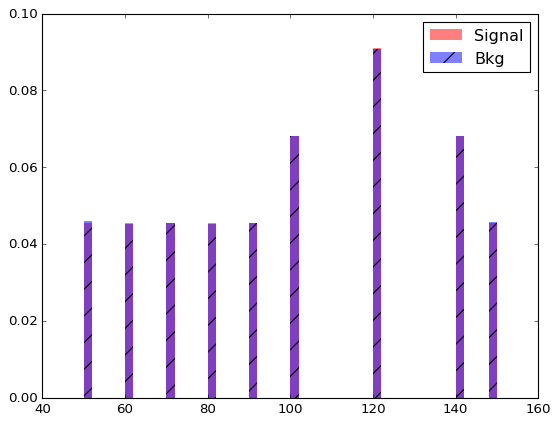

In [11]:
#Result should be 100% overlap between signal and bkg
plt.hist(X_sets[0][y_sets[0]>0].X_mass,weights=w_sets[0][y_sets[0]>0],bins=50,range=[50,150],alpha=0.5,color="red",label="Signal",density=True)
plt.hist(X_sets[0][y_sets[0]<0].X_mass,weights=w_sets[0][y_sets[0]<0],bins=50,range=[50,150],alpha=0.5,color="blue",label="Bkg",density=True,hatch='/')
plt.legend()
plt.show()

### Weight Scaler

The NN is NOT scale invariant and having inputs with different scales usually translates to different scales in weights, making the NN unstable as weights may change by an order of magnitude every step. The idea is to re-scale all inputs so a similar scale is achieved. This information is saved and has to be used to scale the dataset used to evaluate the NN.

The standard scaler will obtain the mean and variance of each input for the training set and then apply x-x0 and x/variance to have distributions with mean 0 and variance 1.

Warning: Distributions with longer tails are not ideal for the training and can perform worse in evaluation

In [12]:
wss = WeightedStandardScaler( )
wss.fit(X_sets[0],y_sets[0],w_sets[0])
for i in range(0,2):
    wss.transform(X_sets[i],y_sets[i],w_sets[i])
wss.export(X_sets[0],y_sets[0],w_sets[0],outputdir,"training_"+str(kfold))
print(wss.mean_,wss.var_,wss.scale_)
print(np.average(X_sets[0],axis=0,weights=w_sets[0]))
print(variance(X_sets[0],weights=w_sets[0]))

Saving info in ./Models/test
(3280339, 32) jet0_pt_bord                0.159343
jet0_eta_bord              -0.002885
jet0_phi_bord               0.000513
jet1_pt_bord                0.181532
jet1_eta_bord              -0.003526
jet1_phi_bord               0.000285
jet2_pt_bord                0.218254
jet2_eta_bord              -0.003319
jet2_phi_bord               0.001030
jet3_pt_bord                0.138597
jet3_eta_bord              -0.002373
jet3_phi_bord               0.000633
jet3_btagw_discrete_bord    0.407701
jet4_pt_bord                0.247222
jet4_eta_bord              -0.001619
jet4_phi_bord              -0.000980
jet4_btagw_discrete_bord    0.332085
jet5_pt_bord                0.256392
jet5_eta_bord              -0.000164
jet5_phi_bord              -0.000727
jet5_btagw_discrete_bord    0.314797
lep1_pt                     0.110225
lep1_eta                   -0.005820
met                         0.197902
met_phi                    -0.001405
mb1b2                       0.22

At this point all the input is prepared for the training. Its possible to save the dataset so the previous steps are skipped for a more efficient work using joblib.dump and load

In [13]:
dump((X_sets,y_sets,w_sets),"Datasetsbackup.sav")
#(X_sets,y_sets,w_sets) = load("Datasetsbackup.sav")

['Datasetsbackup.sav']

# NN

A NN mainly consists in nodes that are connected to each other. The connections are visualizations of weights and the value for a particular node is calculated as $\sum a_i \times w_i+b_i$ over the nodes connected into it, with $a_i$ being the value of the connected node and $w_i$ the weight and $b_i$ an offset. Bigger the connection, bigger the influence. 


The problem that we want to solve is a succesful classification between signal and background events: a classification problem, so the weights of the NN have to be optimised in order to correctly classify events. In order to train, we use a dataset and introduce the input variables (first/input layer) and the label of the event (refered as the truth value of the wanted classification, in this case 0 if background event 1 if signal event) output (last/output layer), which is refered as labels. The NN evaluates the input and calculates a loss function which compares the true output and the predicted output. In an iteration of the training, the loss function is minimised modifying the weights and parameters of the different nodes computing the gradient of the loss as a function of the different parameters and inputs. This process is called back-propagation, being the essence of the NN training. After many iterations of training the loss function is optimised and becomes iteratively more and more precise.

The best feature of the NN is that, in paper, can achieve a perfect minimisation with infinite statistics. Why is that? The NN is parameterising the loss function as a function of the inputs and obtains a gradient that depends on all parameters at the same time, regardless the number of the correlations. Other classifiers can only optimise for each individual input. In reality we face some problems like, how many events should we use for each training step? If we only use one as described before, the process is called stochastic gradient descent and the minimisation in the backpropagation is done with only one event which is typically faster but less precise (the gradient usually translates to very large steps during the minimisation). If all events are used in a backpropagation the process is called batch gradient descent and its the most precise minimisation, altough it consumes a lot of more GPU/CPU resources and if the gradient is not trivial, the minimisation can stop on a local minimum. The most common strategy is to use mini-batch gradient descent where we use a set of the events (like 100 events) for the minimisation which avoids imprecise minimisation while keeping speed and resources.  Additionaly, we use different type of backgrounds events so the "physics" that the NN learns in the backpropagation can be different from different background events.

Some considerations: 
* Feed-forward NN's are structured as sets of connected layers of nodes (the usual structure)
* There can be more than one node at the output for more advanced classifications
* An epoch is defined when the NN has iterated over all dataset. A training can take from tens to hundreds of epochs
* Steps in training are defined as totalevents/batchsize for each epoch
* Bigger the batch size, the more epochs will be needed
* The value on a given node is usually evaluated on an activation function like sigmoid or relu.
 * Sigmoid keeps the value of the node between 0 to 1, very useful for the output node
 * Relu is the usual activation function which makes the node = 0 from node = [-inf,0] and then linear from there.
* Between node layers we add Dropout layers, which prevents a certain amount of weights (usually configured as 10%) to be modified during a given backpropagation. This avoids particular weights to become bigger or more important than others. One could also introduce other functions like weight corrections (avoids differences of the order of magnitute in weights). 
* Calculus regarding gradient is faster on GPU for NN with a lot of parameters
* The dataset for validation is evaluated at the end of each epoch to check that the NN is not overtraining. Overtraining happens when the performance on the training dataset is better than in the validation dataset. This is almost impossible to avoid. However, with the function Early Stopping we can stop the training before the performance in the validation dataset begins to decrease, meaning that the NN is starting to "memorise" the training dataset and continuing the training would lead to a less general training for datasets never seen by the NN.

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt

def getCallbacks(model):
    """ Standard callbacks for Keras Early stopping and checkpoint"""
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        #ModelCheckpoint(filepath='model_nn_'+str(model.configuration)+"_dropout"+str(model.dropout)+"_l2threshold"+str(model.l2threshold)+".hdf5",
        #               monitor='val_loss',
        #                save_best_only=True)  
    ]

def PlotAUCandScore(model,X,y,w,path=""):
    """Function to plot AUC and Score given a HplusNNmodel, features, labels, weights and path to save the plots"""
    y_pred = model.model.predict(X).ravel()
    print(y.unique())
    roc_auc = roc_auc_score(y,y_pred,sample_weight=w)
    fpr, tpr, thresholds = roc_curve(y,y_pred,sample_weight=w)
    plt.figure(figsize=(6.4,4.8),linewidth=0)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate',horizontalalignment='right',x=1,fontsize=14)
    plt.ylabel('True Positive Rate',horizontalalignment='right',y=1,fontsize=14)
    for tick in plt.gca().xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    plt.legend(loc="lower right",fontsize=14,frameon=False)
    plt.grid()
    plt.savefig(path+'_AUC.png',bbox_inches='tight')
    plt.show()

    sumwsig = w[y>0.5].sum()
    sumwbkg = w[y<0.5].sum()
    w_sig = w[y>0.5]/sumwsig
    w_bkg = w[y<0.5]/sumwbkg
    print(w_sig.sum(),w_bkg.sum())
    bins = 50
    plt.figure(figsize=(6.4,4.8),linewidth=0)
    plt.hist(y_pred[y>0.5],weights=w_sig,alpha=0.5,color='r',bins=bins,range=[0,1],density=False,label="Signal") #Signal is everything with label y==1
    plt.hist(y_pred[y<0.5],weights=w_bkg,alpha=0.5,color='b',bins=bins,range=[0,1],density=False,label="Background")
    plt.xlabel("NN score",horizontalalignment='right',x=1,fontsize=14)
    for tick in plt.gca().xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    plt.legend(loc="best",fontsize=14,frameon=False)
    plt.savefig(path+'_Score.png',bbox_inches='tight')
    plt.show()
    return 1.-roc_auc

class FeedForwardModel():
    """ A simple feed forward NN based on Keras"""

    def __init__(self, configuration, l2threshold=None, dropout=None, input_dim=15, verbose=True, activation='relu',learningr=0.00428095):
        """ constructor
        configuration: list of the number of nodes per layer, each item is a layer
        l2threshold: if not None a L2 weight regularizer with threshold <l2threshold> is added to each leayer
        dropout: if not None a dropout fraction of <dropout> is added after each internal layer
        input_dim: size of the training input data
        verbose: if true the model summary is printed
        """
        
        self.callbacks = []
        self.verbose=verbose
        self.configuration=configuration
        self.dropout=dropout
        self.l2threshold=l2threshold
        self.model = Sequential()
        for i,layer in enumerate(configuration):
            if i==0:
                if l2threshold==None:
                    self.model.add(Dense(layer, input_dim=input_dim, activation=activation))    
                else:
                    self.model.add(Dense(layer, input_dim=input_dim, activation=activation, kernel_regularizer=regularizers.l2(l2threshold)))    
            else:
                if l2threshold==None:
                    self.model.add(Dense(layer, activation=activation))
                else:
                    self.model.add(Dense(layer, activation=activation, kernel_regularizer=regularizers.l2(l2threshold)))
            if dropout!=None:
                self.model.add(Dropout(rate=dropout))
        #final layer is a sigmoid for classification
        self.model.add(Dense(1, activation='sigmoid'))
        #model.add(Dense(5, activation='relu'))

        # Compile model
        self.model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learningr))
        self.model.summary()

    def train(self, X_train, y_train, w_train , testData, epochs=100, patience=15, callbacks=None, batch_size=50):
        """ train the Keras model with Early stopping, will return test and training ROC AUC
        trainData: tuple of (X_train, y_train, w_train)
        trainData: tuple of (X_test, y_test, w_test)
        epochs: maximum number of epochs for training
        patience: patience for Early stopping based on validation loss
        callbacks: 
        """

        if callbacks is None:
            self.callbacks.append(EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True))
            #self.callbacks.append(ModelCheckpoint(filepath='model_nn_'+str(self.configuration)+"_dropout"+str(self.dropout)+"_l2threshold"+str(self.l2threshold)+".hdf5", 
            #                                      monitor='val_loss',
            #                                      save_best_only=True))
            #self.callbacks.append(RocCallback(training_data=trainData,validation_data=testData))
        else:
            self.callbacks=callbacks

        if(self.verbose): self.history=self.model.fit(X_train,y_train, sample_weight=w_train,
                                    batch_size=batch_size, epochs=epochs, callbacks=self.callbacks,
                                    validation_data=testData,verbose=1)
        else: self.history=self.model.fit(X_train,y_train, sample_weight=w_train,
                                    batch_size=batch_size, epochs=epochs, callbacks=self.callbacks,
                                    validation_data=testData,verbose=2)

        #self.model.load_weights("model_nn_"+str(self.configuration)+"_dropout"+str(self.dropout)+"_l2threshold"+str(self.l2threshold)+".hdf5")
        y_pred_test=self.model.predict(testData[0]).ravel()
        y_pred_train=self.model.predict(X_train).ravel()
        roc_test =roc_auc_score(testData[1],  y_pred_test,  sample_weight=testData[2])
        roc_train=roc_auc_score(y_train, y_pred_train, sample_weight=w_train)
        #print(self.configuration, roc_test, roc_train)
        
        return roc_test, roc_train
    
    def plotTrainingValidation(self,path=""):
        """draws plots for loss, binary accuracy and ROC AUC"""

        loss_values=self.history.history['loss']
        val_loss_values=self.history.history['val_loss']
        #acc_values=self.history.history['binary_accuracy']
        #val_acc_values=self.history.history['val_binary_accuracy']

        rocauc_values=None
        val_rocauc_values=None
        bestepoch=None
        for cb in self.callbacks:
            if hasattr(cb, 'roc') and hasattr(cb, 'roc_val'):
                rocauc_values=cb.roc
                val_rocauc_values=cb.roc_val
            if hasattr(cb, 'stopped_epoch') and hasattr(cb, 'patience'):
                bestepoch=cb.stopped_epoch-cb.patience+1
  
        epochs=range(1,len(loss_values)+1)
        plt.figure()
        plt.plot(epochs, loss_values, "bo",label="Training loss")
        plt.plot(epochs, val_loss_values, "b",label="Validation loss")
        plt.legend(loc=0)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        if not bestepoch is None:
            plt.axvline(x=bestepoch)
        if path!="":
            plt.savefig(path+'_loss.png')
        plt.show()
            
        #ax=plt.figure()
        #plt.plot(epochs, acc_values, "bo",label="Training acc")
        #plt.plot(epochs, val_acc_values, "b",label="Validation acc")
        #plt.legend(loc=0)
        #plt.xlabel("Epochs")
        #plt.ylabel("Accuracy")
        #if not bestepoch is None:
        #    plt.axvline(x=bestepoch)
        #if path!="":
        #    plt.savefig(path+'_acc.png')
        #plt.show()
        
        if not rocauc_values is None:
            ax=plt.figure()
            plt.plot(epochs, rocauc_values, "bo",label="Training ROC AUC")
            plt.plot(epochs, val_rocauc_values, "b",label="Validation ROC AUC")
            plt.legend(loc=0)
            plt.xlabel("Epochs")
            plt.ylabel("ROC AUC")
            if not bestepoch is None:
                plt.axvline(x=bestepoch)
            plt.show()

Before starting the training, we have to turn the labels into true or false.

In [15]:
for i in range(0,2):
    y_sets[i] = ( y_sets[i] > 0)
    
for i in range(0,3):
    print(X_sets[i].shape)

(3280339, 32)
(1094373, 32)
(1094368, 32)


Define the model and trains it.

configuration=[64,64] sets the shape of the NN to be 2 hidden layers of 64 nodes.
dropout=0.1 sets the dropout between hiden layers to be 10%
batch_size=128 is the number of events to use in the gradient decent
epochs=300 the maximum amount of epochs allowed
patience = 5 if in 5 epochs the performance in the validation dataset is not improved, the training is stopped (usually should be 15)


In order to save the trained NN model, we save the architecture and the weights in different files.

After training, different distributions are plotted

* The evolution of the loss function for each epoch for the training and validation datasets
* The NN output after evaluating the validation dataset for signal and background
* The Reciever Operating Characteristic (ROC curve) shows the True positive rate for a given False positive rate.
    * If we wanted to cut the NN output on a given point to accept Y amount of signal, the ROC curve tells you the X amount of background that you are accepting aswell.
    * The Area Under the ROC Curve is common indicator of the performance as it indicates the amount of overap between the signal and background NN output distributions. If the AUC = 1, you can define a cut in NN output with True Positive rate = 1 at any rate of False positive meaning that the distributions are completely separated. If the distributions are overlapped, the true positive rate and false positive rate are proportional and the AUC is 0.5.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               8250      
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               6

2021-10-21 13:54:18.142258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


1094/1094 [==============================] - 9s 8ms/step - loss: 1.9977e-07 - val_loss: 5.5274e-07
Epoch 2/300
1094/1094 [==============================] - 9s 8ms/step - loss: 1.8172e-07 - val_loss: 5.1564e-07
Epoch 3/300
1094/1094 [==============================] - 9s 8ms/step - loss: 1.7358e-07 - val_loss: 4.9889e-07
Epoch 4/300
1094/1094 [==============================] - 9s 8ms/step - loss: 1.6987e-07 - val_loss: 4.9286e-07
Epoch 5/300
1094/1094 [==============================] - 9s 8ms/step - loss: 1.6732e-07 - val_loss: 4.8631e-07
Epoch 6/300
1094/1094 [==============================] - 8s 8ms/step - loss: 1.6549e-07 - val_loss: 4.8373e-07
Epoch 7/300
1094/1094 [==============================] - 9s 8ms/step - loss: 1.6429e-07 - val_loss: 4.8140e-07
Epoch 8/300
1094/1094 [==============================] - 9s 8ms/step - loss: 1.6307e-07 - val_loss: 4.7895e-07
Epoch 9/300
1094/1094 [==============================] - 9s 8ms/step - loss: 1.6236e-07 - val_loss: 4.7575e-07
Epoch 10/300


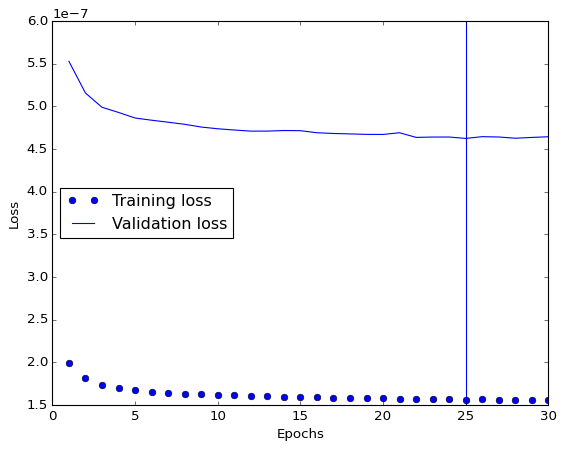

[False  True]


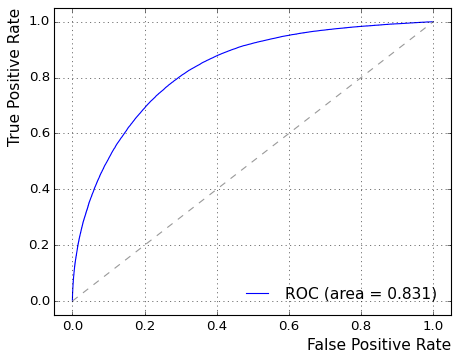

0.9999999999999999 1.0000000000000004


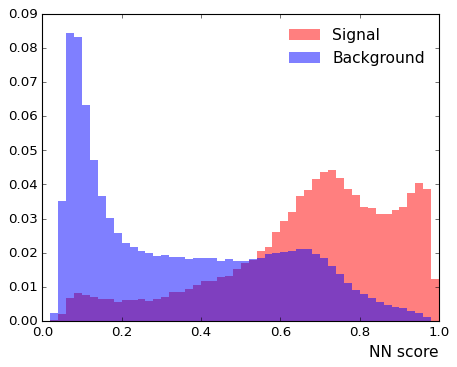

0.1688048186467619

In [16]:
structure = [250,250,250,250,250]
dropout = 0.25
bsize = 3000
verbose = True
learningrate = 0.1778279410038923

modelNN=FeedForwardModel(configuration=structure,dropout=dropout,verbose=verbose, input_dim=X_sets[0].shape[1],learningr=learningrate)
resultNN=modelNN.train(X_sets[0], y_sets[0], w_sets[0],(X_sets[1], y_sets[1], w_sets[1]),batch_size = bsize, epochs=300,patience=5,callbacks=getCallbacks(modelNN))
print(resultNN)
arch_file=open(outputdir+'/architecture.h5','w') #save architecture for analysis framework
arch_file.write(modelNN.model.to_json())
arch_file.close()
modelNN.model.save_weights(outputdir+'/weights.h5') #Save weights for analysis framework
modelNN.plotTrainingValidation(outputdir+'/Validation') #in HpKerasUtils to save performance of each epoch
PlotAUCandScore(modelNN,X_sets[1],y_sets[1],w_sets[1],outputdir+'/Validation') #Validating the NN input

# Evaluation

In order to validate the training in deferent regions or individual masses the training has to be loaded.

Careful to use the same input, use the correct kfold, dataset for evaluation and apply the same weighted scaler

In [18]:
inputdir = outputdir
outputdir = inputdir+"/Eval"
kfold=0
mass=120
if not os.path.isdir(outputdir):
    print("Making output dir",outputdir) #output dir to store training output and plots
    os.makedirs(outputdir, exist_ok=True)

from keras.models import model_from_json
df_mc = pd.read_feather("/tmp/"+user+"/"+pandainput)
df_mc = df_mc[~((df_mc.X_mass==160)&(df_mc.nomWeight_weight_mc > 700))] #removing some wrong events and regions
df_mc = df_mc[~((df_mc.region=="c1l7jin3bex")|(df_mc.region=="c1l7jin4bin"))]
df_mc["weight"]*=139000.0

#We need to apply the same modifications to the dataset
if reframelep_phi: 
    for i in range(0,6):
        df_mc["jet"+str(i)+"_phi_bord"]=df_mc["jet"+str(i)+"_phi_bord"]-df_mc["lep1_phi"]
        df_mc.loc[(df_mc["jet"+str(i)+"_phi_bord"]>np.pi),"jet"+str(i)+"_phi_bord"] -= 2*np.pi 
        df_mc.loc[(df_mc["jet"+str(i)+"_phi_bord"]< -np.pi),"jet"+str(i)+"_phi_bord"] += 2*np.pi

    df_mc["met_phi"]=df_mc["met_phi"]-df_mc["lep1_phi"]
    df_mc.loc[(df_mc["met_phi"]>np.pi),"met_phi"] -= 2*np.pi
    df_mc.loc[(df_mc["met_phi"]< -np.pi),"met_phi"] += 2*np.pi
        
#in order to do plots for every analysis region and process, we will keep the information of the region and process variables
tframe = TrainingFrame(df_mc[df_mc.weight!=0],features+["region","process"])
tf_ = tframe.prepare(masses=[mass],addmass=True)
X_sets,y_sets,w_sets = [tf_[0:3],tf_[3:6],tf_[6:]]
del df_mc,tf_ #to free space

#lets store region and process in a separate object
reg_sets = []
proc_sets = []
for i in range(0,3):
    X_sets[i].X_mass = mass #need to assign the mass hypothesis we evaluate
    reg_sets.append(X_sets[i].region)
    proc_sets.append(X_sets[i].process)
    X_sets[i] = X_sets[i].drop(columns=["region","process"])

#load and apply the transformation
wss = load(inputdir+'/wss_training_'+str(kfold)+'.joblib')

for i in range(0,3):
    wss.transform(X_sets[i],y_sets[i],w_sets[i])

#set the label.
for i in range(0,3):
    y_sets[i] = ( y_sets[i] > 0)
    
#Load the NN
json_file = open(inputdir+'/architecture.h5')
loaded_model_json = json_file.read()
json_file.close()

modelNN = model_from_json(loaded_model_json)
modelNN.load_weights(inputdir+'/weights.h5')

#Evaluate the NN
y_ts_pred = modelNN.predict(X_sets[1])
y_tr_pred = modelNN.predict(X_sets[0])
y_ev_pred = modelNN.predict(X_sets[2])

#Calculate the AUC
roc_ts = roc_auc_score(y_sets[1], y_ts_pred, sample_weight=w_sets[1])
roc_tr = roc_auc_score(y_sets[0], y_tr_pred, sample_weight=w_sets[0])
roc_ev = roc_auc_score(y_sets[2], y_ev_pred, sample_weight=w_sets[2])
print("____________\nAUC test\t AUC train\t AUC eval\n",roc_ts,roc_tr,roc_ev)

____________
AUC test	 AUC train	 AUC eval
 0.7532808328275037 0.7636025947003815 0.7517598823312054


This plotting section should be done on another part and normally with all the folds trained, this is just an example

In [19]:
def getseparation(nu,n,bins):
    """Chi^2 histogram based separation to compare with other analyses. """
    print("get separation")
    separation = 0
    binsize = float(bins[-1]-bins[0])/float(len(n))
    print(binsize)
    S = sum(nu)*binsize
    B = sum(n)*binsize
    print(S,B)
    for i in range(len(n)):
        s = nu[i]/S
        b = n[i]/B
        if (s+b)>0:
            separation+=(s-b)*(s-b)/(s+b)
        print(i, s, b, separation)
    separation*=binsize*0.5
    return separation

0.9999999999999997 1.0 1.0


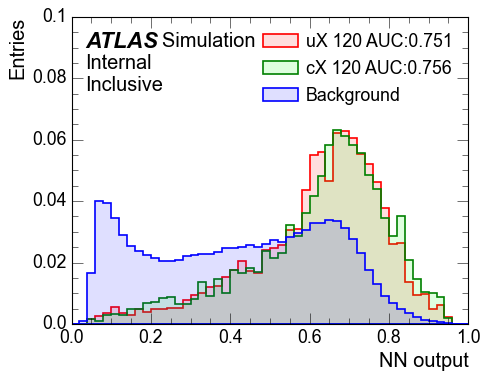

In [20]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import matplotlib.ticker as tck
from matplotlib import get_data_path
plt.style.use('classic')
rcParams['figure.facecolor'] = '1'
rcParams['patch.force_edgecolor'] = False
rcParams["legend.handletextpad"] = 0.4
fpath = os.path.join(get_data_path(), "/nfs/pic.es/user/s/salvador/arial.ttf")
fbipath = os.path.join(get_data_path(), "/nfs/pic.es/user/s/salvador/ArialBoldItalic.ttf")

labels = {'all': "Inclusive","c1l4jex3bex": "4j 3b","c1l4jex4bin": r'4j 4b', "c1l5jex3bex":"5j 3b", "c1l5jex4bin": "5j "+r'$\geq$'+"4b",
          "c1l6jin3bex": r'$\geq$6j'+" 3b","c1l6jin4bin": r'$\geq$6j$\geq$4b'}
#regions= ['all','c1l4jex3bex','c1l4jex4bin', 'c1l5jex3bex','c1l5jex4bin','c1l6jin3bex','c1l6jin4bin']
regions= ['all'] #keeping it simple
mass=120

for region in regions:
    if region=="all":
        y,y_pred,w = [y_sets[1],y_ts_pred,w_sets[1]]
        proc = proc_sets[1]
    else:
        y,y_pred,w = [y_sets[1][reg_sets[1]==region],y_ts_pred[reg_sets[1]==region],w_sets[1][reg_sets[1]==region]]
        proc = proc_sets[1][reg_sets[1]==region]
    auc = roc_auc_score(y, y_pred, sample_weight=w)

    umask = ((proc=="uX_"+str(mass)) | (proc=="ubarX_"+str(mass)))
    cmask = ((proc=="cX_"+str(mass)) | (proc=="cbarX_"+str(mass)))
    
    umasknot = ~((proc.str.contains("uX_")) | (proc.str.contains("ubarX_")) | (proc=="data"))
    cmasknot = ~((proc.str.contains("cX_")) | (proc.str.contains("cbarX_")) | (proc=="data"))
    
    aucu = roc_auc_score(y[cmasknot], y_pred[cmasknot], sample_weight=w[cmasknot])
    aucc = roc_auc_score(y[umasknot], y_pred[umasknot], sample_weight=w[umasknot])

    
    #sumwsig = w[y>0.5].sum()
    sumwsigu = w[umask].sum()
    sumwsigc = w[cmask].sum()
    sumwbkg = w[y<0.5].sum()
    #w_sig = w[y>0.5]/sumwsig
    w_sigu = w[umask]/sumwsigu
    w_sigc = w[cmask]/sumwsigc
    w_bkg = w[y<0.5]/sumwbkg
    print(w_bkg.sum(),w_sigu.sum(),w_sigc.sum())
    bins = 50
    ymulti = 1.35
    yscale = 0.95

    plt.figure(figsize=(6.4,4.8),linewidth=0)
    plt.hist(y_pred[umask],weights=w_sigu,bins=bins,range=[0,1],density=False,fc=(1,0,0,0.125),ec="r",linewidth=1.5,label="uX "+str(mass)+" AUC:"+str(round(aucu,3)),histtype='stepfilled') #Signal is everything with label y==1
    plt.hist(y_pred[cmask],weights=w_sigc,bins=bins,range=[0,1],density=False,fc=(0,1,0,0.125),ec="g",linewidth=1.5,label="cX "+str(mass)+" AUC:"+str(round(aucc,3)),histtype='stepfilled') #Signal is everything with label y==1
    plt.hist(y_pred[y<0.5],weights=w_bkg,bins=bins,range=[0,1],density=False,fc=(0,0,1,0.125),ec="b",linewidth=1.5,label="Background",histtype='stepfilled')
    plt.xlabel("NN output",horizontalalignment='right',x=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
    plt.ylabel("Entries",horizontalalignment='right',y=1,fontproperties=fm.FontProperties(fname=fpath,size=18))
    plt.xlim(0.,1.)
    plt.ylim(0.,plt.gca().get_ylim()[1]*ymulti)
    plt.gca().set_xticks(plt.gca().get_xticks().tolist())
    plt.gca().set_yticks(plt.gca().get_yticks().tolist())
    plt.gca().set_yticklabels([round(num,2) for num in plt.gca().get_yticks()], fontproperties=fm.FontProperties(fname=fpath,size=16))
    plt.gca().yaxis.set_minor_locator(tck.AutoMinorLocator())
    plt.gca().set_xticklabels([round(num,2) for num in plt.gca().get_xticks()], fontproperties=fm.FontProperties(fname=fpath,size=16))
    plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
    plt.gca().tick_params(length=10, width=0.5)
    plt.gca().tick_params(which="minor",length=5, width=0.5)
    plt.text(0.035,plt.gca().get_ylim()[1]*yscale,"ATLAS",va='top',ha='left',fontproperties=fm.FontProperties(fname=fbipath,size=20))
    plt.text(0.035,plt.gca().get_ylim()[1]*yscale,"              Simulation\nInternal",va='top',ha='left',fontproperties=fm.FontProperties(fname=fpath,size=18))
    plt.text(0.035,plt.gca().get_ylim()[1]*yscale,"\n\n"+labels[region],va='top',ha='left',fontproperties=fm.FontProperties(fname=fpath,size=18))

    plt.legend(loc="best",prop=fm.FontProperties(fname=fpath,size=16),frameon=False)
    plt.savefig(outputdir+'/Score_'+region+'.png',bbox_inches='tight')
    plt.show()